In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import re

## Loading data

In [86]:
data = pd.read_csv("../../cancer_data/OmicsExpressionProteinCodingGenesTPMLogp1.csv", index_col = 0)  
data.columns = [re.match(r'([^\s]+)', col).group(1) for col in data.columns]

In [96]:
#from DepMap
all_DR = pd.read_csv("sanger-dose-response.csv")
#selecting the GDSC2
GDSC2_DR = all_DR[all_DR["DATASET"] == "GDSC2"]

## Preparing data for the chosen drug

In [88]:
vorinostat = GDSC2_DR[GDSC2_DR["DRUG_NAME"] == "VORINOSTAT"]

In [89]:
print(vorinostat.ARXSPAN_ID.shape)
print(vorinostat.ARXSPAN_ID.unique().shape)

(761,)
(745,)


In [90]:
#there are some cell lines that don't have ARXSPAN_ID (although it was downloaded from the DepMap portal)
#print(vorinostat[vorinostat.duplicated(['ARXSPAN_ID'], keep=False)])

#dropping them 
vorinostat = vorinostat[vorinostat['ARXSPAN_ID'].notna()]
vorinostat

,DATASET,COSMIC_ID,DRUG_ID,MIN_CONC,MAX_CONC,RMSE_PUBLISHED,Z_SCORE_PUBLISHED,IC50_PUBLISHED,AUC_PUBLISHED,ARXSPAN_ID,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
274086,GDSC2,910927,1012,0.004883,10.0,0.069028,-0.372436,3.412435,0.804515,ACH-000856,VORINOSTAT,BRD-K81418486,0.964990,6.265313,-1.201283,-0.140845,0.842721,2.262152,0.001488,0.961631
274087,GDSC2,908120,1012,0.004883,10.0,0.103842,-0.273306,3.832430,0.770433,ACH-000759,VORINOSTAT,BRD-K81418486,0.935137,81.110634,-0.803588,-3.398633,0.814775,2.405193,0.004306,0.864482
274088,GDSC2,749712,1012,0.004883,10.0,0.077677,1.033259,17.696821,0.894765,ACH-000699,VORINOSTAT,BRD-K81418486,0.950944,2.745120,-3.744558,0.711829,0.910336,NaN,0.001994,0.761551
274089,GDSC2,908122,1012,0.004883,10.0,0.171677,-1.772702,0.662208,0.622997,ACH-000910,VORINOSTAT,BRD-K81418486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274090,GDSC2,910852,1012,0.004883,10.0,0.111104,0.571882,10.310368,0.864613,ACH-000857,VORINOSTAT,BRD-K81418486,0.959633,5.319263,-1.976062,0.213904,0.885395,2.757360,0.004956,0.791644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274842,GDSC2,908150,1012,0.010005,10.0,0.042395,0.918562,15.472806,0.889689,ACH-000319,VORINOSTAT,BRD-K81418486,0.973936,8.470242,-1.336187,0.368567,0.920801,NaN,0.000311,0.977370
274843,GDSC2,924187,1012,0.010005,10.0,0.098515,0.632606,11.070147,0.806377,ACH-000293,VORINOSTAT,BRD-K81418486,0.974471,6.374075,-1.151235,0.170215,0.874846,3.128050,0.000967,0.969511
274844,GDSC2,909716,1012,0.010005,10.0,0.120769,-0.819732,2.021173,0.737417,ACH-001189,VORINOSTAT,BRD-K81418486,0.969623,2.172746,-3.231929,0.153524,0.788991,1.255274,0.000555,0.994733
274845,GDSC2,1295740,1012,0.010005,10.0,0.116152,-1.317431,1.128523,0.675730,ACH-000105,VORINOSTAT,BRD-K81418486,0.970203,1.083892,-10.082407,0.078950,0.683490,0.132033,0.001593,0.989584


In [91]:
vorinostat = vorinostat.set_index("ARXSPAN_ID")
vorinostat.index.name = None
vorinostat["Sensitivity"] = (vorinostat["IC50_PUBLISHED"] < max_conc).astype(int)
vorinostat_IC50 = vorinostat[['IC50_PUBLISHED']]
vorinostat_sensitivity = vorinostat[['Sensitivity']]

In [92]:
print(vorinostat.MAX_CONC.unique())
max_conc = vorinostat.MAX_CONC.unique()[0]

[10.]


In [93]:
#trying to understand the overlap between DepMap transcriptomics data and Vorinostat data 
vorinostat_cell_lines_index = list(vorinostat_sensitivity.index)
data_cell_lines_index = list(data.index)
overlap = list(set(vorinostat_cell_lines_index) & set(data_cell_lines_index))
print(len(data_cell_lines_index))
print(len(vorinostat_cell_lines_index))
print(len(overlap))

1450
744
568


In [94]:
data_DR = pd.merge(data, vorinostat_sensitivity, left_index=True, right_index=True)


<Axes: >

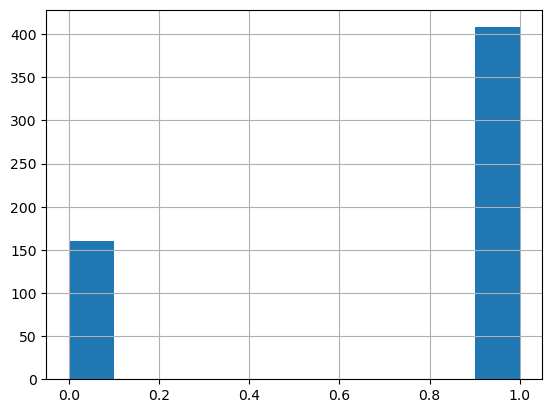

In [95]:
data_DR["Sensitivity"].hist()

## Decision tree trial

Tutorial: https://www.datacamp.com/tutorial/decision-tree-classification-python

In [111]:
#feature selection
X = data_DR.drop('Sensitivity', axis=1) # Features
feature_cols = list(X.columns)
y = data_DR.Sensitivity # Target variable

In [99]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [100]:
#building a decision tree 

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



In [101]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6140350877192983


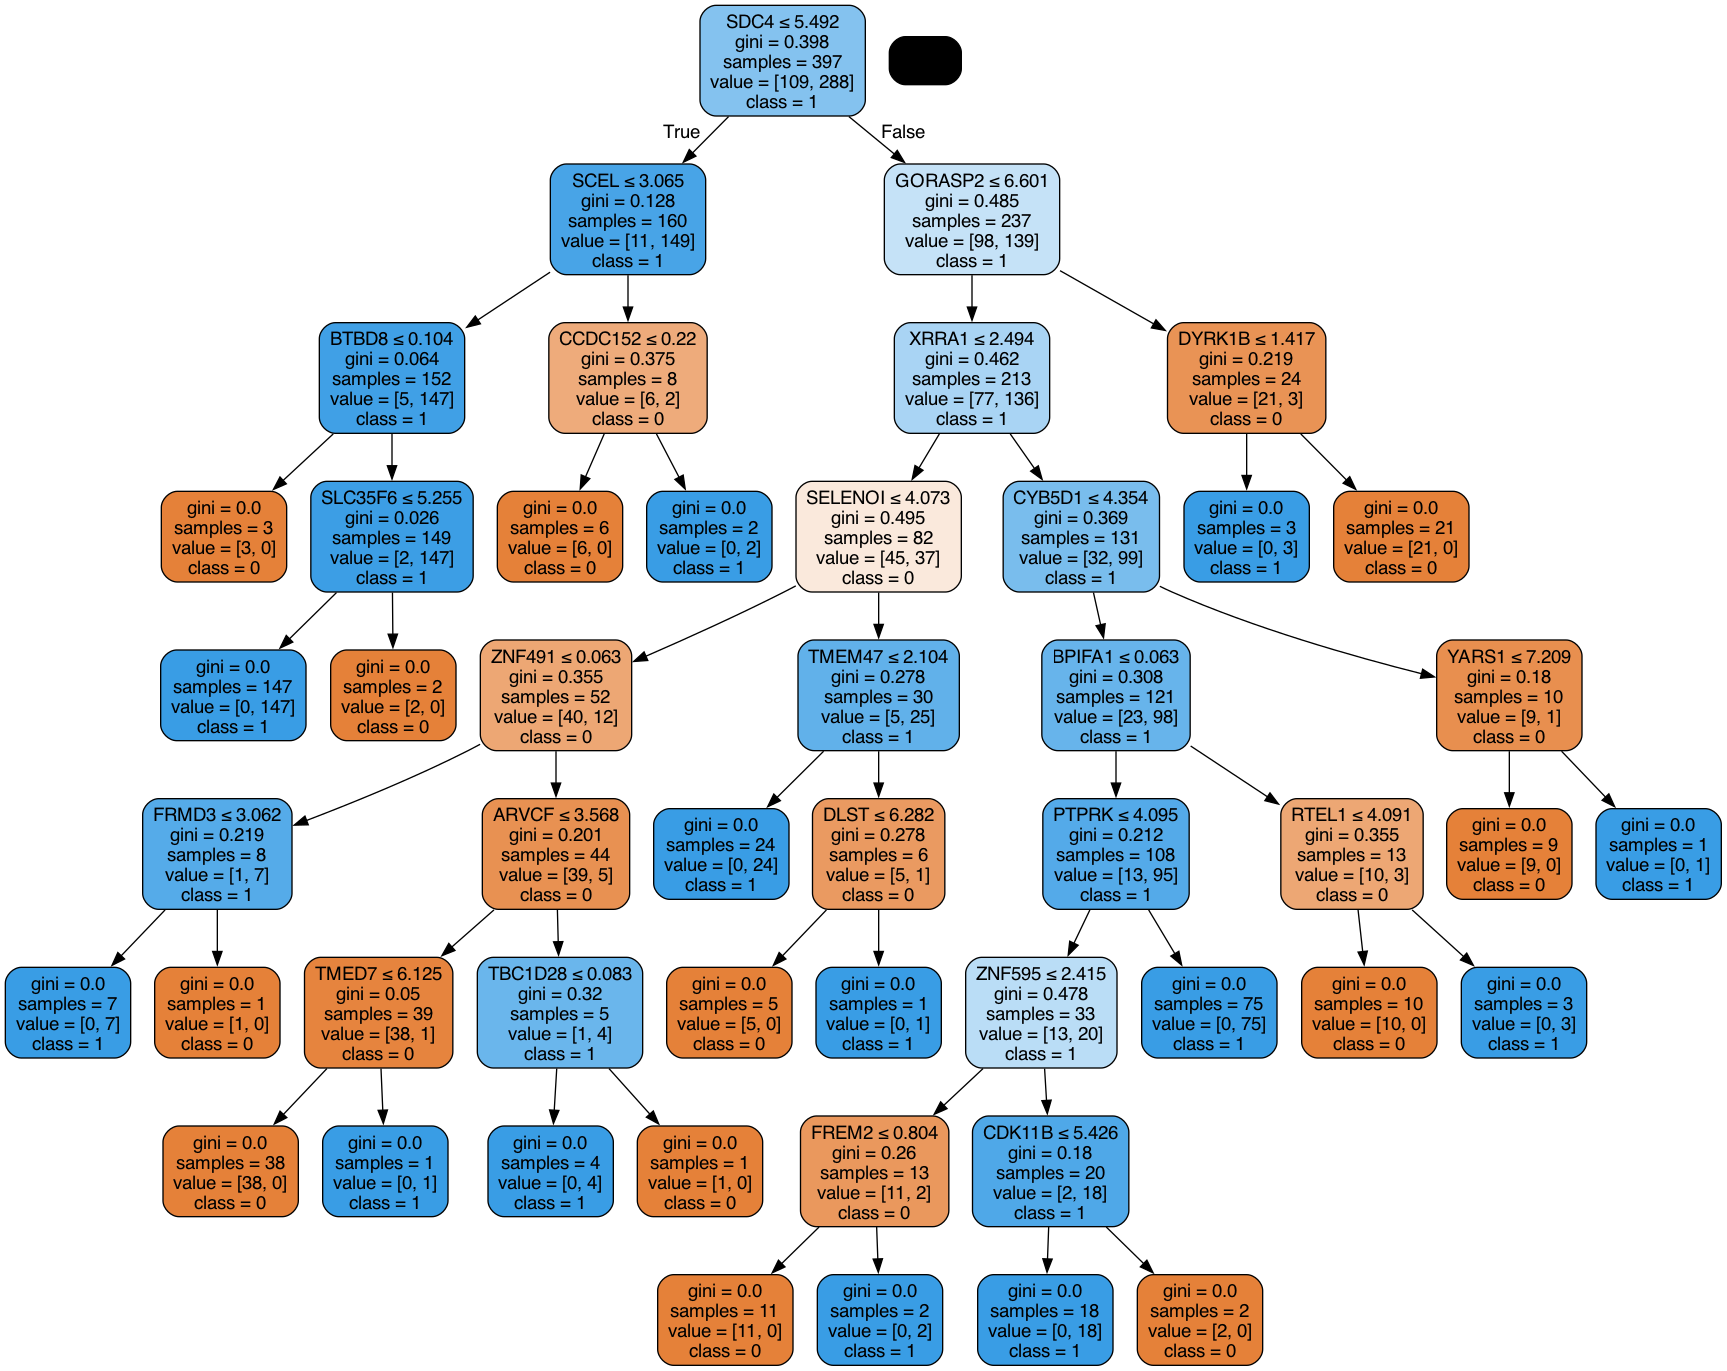

In [114]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree_vorinostat_all_genes.png')
Image(graph.create_png())


## Random forest Trial

Tutorial https://www.datacamp.com/tutorial/random-forests-classifier-python 

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


In [117]:
#feature selection
X = data_DR.drop('Sensitivity', axis=1) # Features
y = data_DR.Sensitivity # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [118]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [119]:
y_pred = rf.predict(X_test)

In [120]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7982456140350878


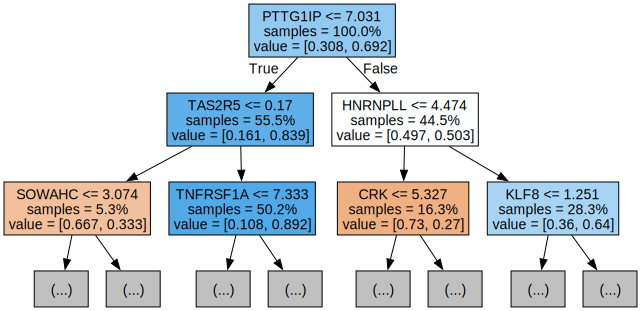

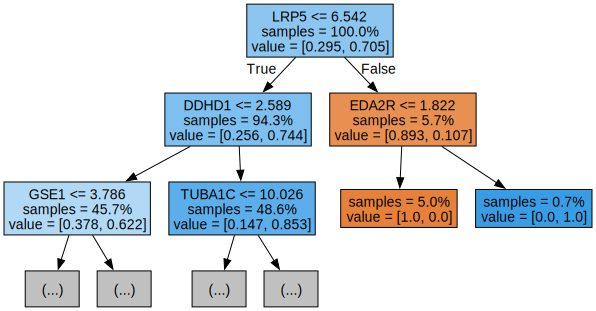

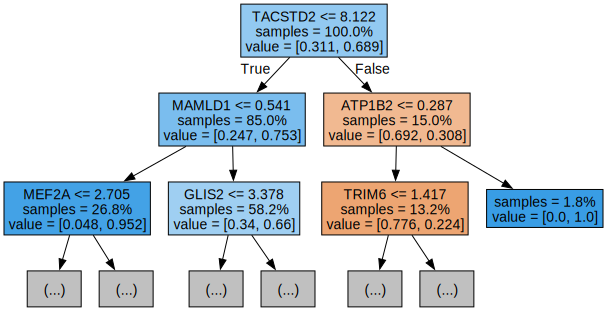

In [124]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Random Forest Classifier on ERN genes

In [125]:
ERN_genes_df = pd.read_excel('../../ERN_genes_tables/ERN_genes.xlsx')
ERN_genes = ERN_genes_df['Gene']


In [128]:
#feature selection
X = data_DR[ERN_genes] # Features
y = data_DR.Sensitivity # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [130]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [131]:
y_pred = rf.predict(X_test)

In [132]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7456140350877193


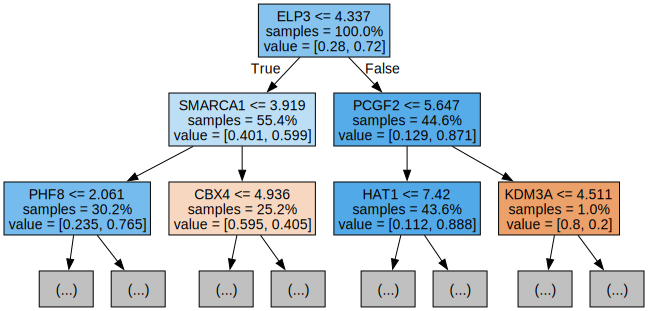

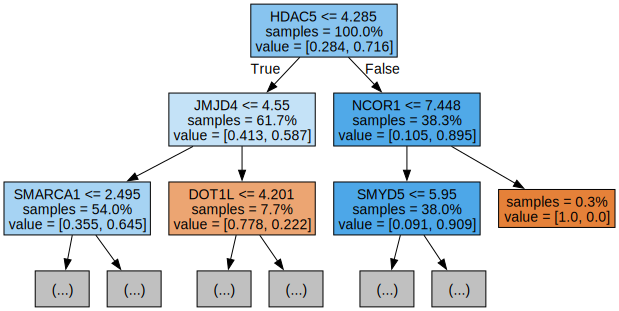

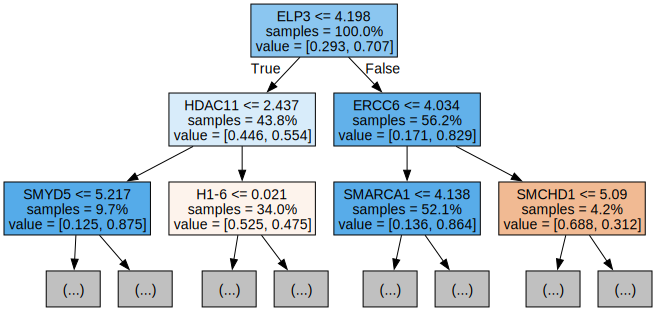

In [133]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)